# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !cd "/content/drive/My Drive/CV/assignment1/cs231n/datasets" && wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 
# !cd "/content/drive/My Drive/CV/assignment1/cs231n/datasets" && tar -xzvf cifar-10-python.tar.gz
# #!cd "/content/drive/My Drive/CV/assignment1/cs231n/datasets" && rm cifar-10-python.tar.gz 
#!pip install Pillow

In [0]:
import sys
import os
import importlib

In [0]:
WRK_DIR = "/content/drive/My Drive/CV/assignment1"
sys.path.append(WRK_DIR)

In [0]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
# importlib.reload(load_CIFAR10)
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = os.path.join(WRK_DIR, 'cs231n/datasets/cifar-10-batches-py')

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


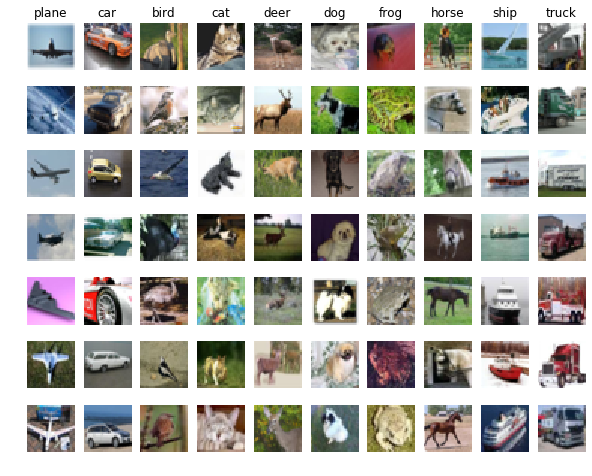

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [9]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


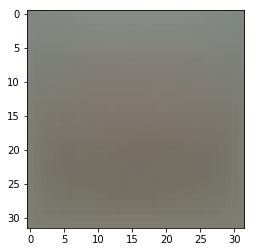

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [10]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

### linear_svm.py

In [0]:
# from builtins import range
# import numpy as np
# from random import shuffle
# from past.builtins import xrange

# def svm_loss_naive(W, X, y, reg):
#     """
#     Structured SVM loss function, naive implementation (with loops).

#     Inputs have dimension D, there are C classes, and we operate on minibatches
#     of N examples.

#     Inputs:
#     - W: A numpy array of shape (D, C) containing weights.
#     - X: A numpy array of shape (N, D) containing a minibatch of data.
#     - y: A numpy array of shape (N,) containing training labels; y[i] = c means
#       that X[i] has label c, where 0 <= c < C.
#     - reg: (float) regularization strength

#     Returns a tuple of:
#     - loss as single float
#     - gradient with respect to weights W; an array of same shape as W
#     """
#     dW = np.zeros(W.shape) # initialize the gradient as zero

#     # compute the loss and the gradient
#     num_classes = W.shape[1]
#     num_train = X.shape[0]
#     loss = 0.0
#     for i in range(num_train):
#         scores = X[i].dot(W)
#         correct_class_score = scores[y[i]]
#         for j in range(num_classes):
#             if j == y[i]:
#                 continue
#             margin = scores[j] - correct_class_score + 1 # note delta = 1
#             if margin > 0:
#                 loss += margin

    
#     # Right now the loss is a sum over all training examples, but we want it
#     # to be an average instead so we divide by num_train.
#     loss /= num_train

#     # Add regularization to the loss.
#     loss += .5 * reg * np.sum(W * W)

#     #############################################################################
#     # TODO:                                                                     #
#     # Compute the gradient of the loss function and store it dW.                #
#     # Rather that first computing the loss and then computing the derivative,   #
#     # it may be simpler to compute the derivative at the same time that the     #
#     # loss is being computed. As a result you may need to modify some of the    #
#     # code above to compute the gradient.                                       #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
#     for i in range(num_train):
#         # X=[N,D], X[i]=[1,D], W=[D, C]
#         # scores = [1, C]
#         scores = X[i].dot(W)
#         # y=[N,1]
#         # field(y[i]) = C
#         # correct_class_score=[1,1]
#         correct_class_score = scores[y[i]]
#         indicator_sum = 0
#         for j in range(num_classes):
#             if j == y[i]:
#                 continue
#             margin = scores[j] - correct_class_score + 1
#             if margin > 0:
#                 indicator_sum += 1
#                 dW[:, j] += X[i]
#         dW[:,y[i]] -= indicator_sum*X[i]
#     dW/=num_train
#     dW+=reg*W
            

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
#     return loss, dW



# def svm_loss_vectorized(W, X, y, reg):
#     """
#     Structured SVM loss function, vectorized implementation.

#     Inputs and outputs are the same as svm_loss_naive.
#     """
#     loss = 0.0
#     dW = np.zeros(W.shape) # initialize the gradient as zero

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the structured SVM loss, storing the    #
#     # result in loss.                                                           #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     N = X.shape[0]
#     # X=[N,D] W=[D,C] scores=[N,C]
#     scores = X.dot(W)
#     # y=[N,1] field(y)=C^N, C=classes
#     # correct_class_score=[N,1]
#     # correct_class_score - cntains score of correct classes
#     correct_class_scores = scores[np.arange(N), y]
#     margins = np.maximum(scores-correct_class_scores.reshape(N,1)+1,0)
#     margins[np.arange(N),y] = 0
#     loss = np.mean(np.sum(margins, axis=1))+.5*reg*np.sum(W*W)
    

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the gradient for the structured SVM     #
#     # loss, storing the result in dW.                                           #
#     #                                                                           #
#     # Hint: Instead of computing the gradient from scratch, it may be easier    #
#     # to reuse some of the intermediate values that you used to compute the     #
#     # loss.                                                                     #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     dscores = np.zeros_like(scores)
#     dscores[margins>0] = 1
#     dscores[np.arange(N),y] -= np.sum(dscores, axis=1)
#     dW = X.T.dot(dscores)/N+reg*W
    

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW

### softmax.py


$o_i$ and derivative of $o_i$:
$$ o_i = \sum_{c}w_{ic}x_c $$
$$ \frac{\partial o_i}{\partial w_{ic}} = x_c$$

Sofmax ($c \in C $ - categories of classification):
$$ p_j = e^{o_j} \big/ {\sum_{c \in C}{e^{o_c}}} 
=e^{o_j} \bigg( \sum_{c \in C}{e^{o_c}} \bigg)^{-1}
$$

normalisation trick to prevent large variatio of numerator and denominator:
$$  
p_j = e^{o_j} \big/ {\sum_{c \in C}{e^{o_c}}} 
= A e^{o_j} \big/ \bigg[ A{\sum_{c \in C}{e^{o_c}}} \bigg]=
$$
$$
=e^{o_j+log\ A} \big/ {\sum_{c \in C}{e^{o_c+log\ A}}}
$$
$$
where\ A=-log[max(o_1,..,o_j,...o_C)]
$$

derivative of softmax by $o_j$:
$$ 
\frac{\partial p_j}{\partial o_j}
=\frac{\partial }{\partial o_j} \bigg[ e^{o_j} \big/ {\sum_{c \in C}{e^{o_c}}} \bigg]
=\frac
  {e^{o_j} \sum_{c}{e^{o_c}} + e^{o_j}e^{o_j}} 
  { \big( \sum_{c}{e^{o_c}} \big)^2}
=p_j-(p_j)^2=p_j(1-p_j)
$$

derivative of softmax by $o_i$ ($i \ne j$):
$$\frac{\partial p_j}{\partial o_i}
=\frac{\partial}{\partial o_j} \bigg[
e^{o_j} \big( \sum_{c}{e^{o_c}} \big)^{-1}\bigg]
= - e^{o_j} \big( \sum_{c}{e^{o_c}} \big)^{-2} e^{o_i}
=$$
$$=- \frac{e^{o_j}e^{o_j}}{ \big( \sum_{c}{e^{o_c}} \big)^{-2} } = - p_ip_j
$$

cross-entropy loss (aka softmax loss):
$$L=-\sum_{c}{y_c log(p_c)}$$
derivatives for cross-entropy loss ($p_c$ - softmax):
$$
\frac{\partial L}{\partial o_j}
=\frac{\partial}{\partial o_j}
\bigg[-\sum_{c}{y_c log(p_c)} \bigg]
=-\sum_{c}\bigg[
{y_c \frac{\partial (log\ p_c)}{\partial o_j}}
\bigg]=
$$
$$=-y_j \frac{1}{p_j}p_j(1-p_j)+
\sum_{c \ne j}
\bigg[y_c\frac{1}{p_c}p_cp_j\bigg]
=$$
$$=-y_j+y_jp_j
+\sum_{c \ne j}\bigg[
y_cp_j
\bigg]
=-y_j+y_jp_j+p_j\sum_{c \ne j}{y_c}=
$$
$$=-y_j+p_j \sum_{c}{y_c}=-y_j+p_j=p_j-y_j$$
So the derivative of cross-entropy is the following
$$ \frac{\partial L}{\partial o_j} =  p_j-y_j$$

In [0]:
# from math import exp

# def softmax_loss_naive(W, X, y, reg):
#     """
#     Softmax loss function, naive implementation (with loops)

#     Inputs have dimension D, there are C classes, and we operate on minibatches
#     of N examples.

#     Inputs:
#     - W: A numpy array of shape (D, C) containing weights.
#     - X: A numpy array of shape (N, D) containing a minibatch of data.
#     - y: A numpy array of shape (N,) containing training labels; y[i] = c means
#       that X[i] has label c, where 0 <= c < C.
#     - reg: (float) regularization strength

#     Returns a tuple of:
#     - loss as single float
#     - gradient with respect to weights W; an array of same shape as W
#     """
#     # Initialize the loss and gradient to zero.
#     loss = 0.0
#     dW = np.zeros_like(W)

#     #############################################################################
#     # TODO: Compute the softmax loss and its gradient using explicit loops.     #
#     # Store the loss in loss and the gradient in dW. If you are not careful     #
#     # here, it is easy to run into numeric instability. Don't forget the        #
#     # regularization!                                                           #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     # https://datascience.stackexchange.com/questions/29735/how-to-apply-the-gradient-of-softmax-in-backprop
#     # https://stackoverflow.com/questions/41663874/cs231n-how-to-calculate-gradient-for-softmax-loss-function

#     N = X.shape[0] #number of observations
#     C = W.shape[1] #number of classes
#     D = W.shape[0] #number of dimentions
    
#     p = np.zeros([N, C])
    
#     for i in range(N):
#         exp_o=np.exp()
#         for c in range(C):
#             exp_o = exp(np.inner(X[i,:], W[:,c]) #o[i,c]
#             #TODO: normalisation trick
#             #http://cs231n.github.io/linear-classify/#softmax
#             #https://stackoverflow.com/questions/41663874/cs231n-how-to-calculate-gradient-for-softmax-loss-function
#             p[i, c] = exp(o)
#         p[i,:]/=p[i,:].sum()
    
#     loss = -np.sum(np.log(p))/N + .5*reg*np.sum(W*W)
    
    
#     for d in range(D):
#         for c in range(C):
#             for i in range(N):
#                 dW[d,c] += (p[i,c]-(c==y[i]))*X[i,d]
#     dW=dW/N+reg*W
    
#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW


# def softmax_loss_vectorized(W, X, y, reg):
#     """
#     Softmax loss function, vectorized version.

#     Inputs and outputs are the same as softmax_loss_naive.
#     """
#     # Initialize the loss and gradient to zero.
#     loss = 0.0
#     dW = np.zeros_like(W)

#     #############################################################################
#     # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
#     # Store the loss in loss and the gradient in dW. If you are not careful     #
#     # here, it is easy to run into numeric instability. Don't forget the        #
#     # regularization!                                                           #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    
#     pass

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW

### main

In [0]:
a = np.array([2,3,4,5])
y = np.array([2])

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.143219


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [15]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 6.655199 analytic: 6.655199, relative error: 2.782097e-11
numerical: -10.984229 analytic: -10.984229, relative error: 3.578070e-11
numerical: -0.252108 analytic: -0.252108, relative error: 3.450258e-10
numerical: 8.826883 analytic: 8.826883, relative error: 8.698167e-12
numerical: 14.742446 analytic: 14.742446, relative error: 1.242255e-11
numerical: 11.983326 analytic: 11.983326, relative error: 1.408980e-13
numerical: 12.100696 analytic: 12.100696, relative error: 1.114299e-11
numerical: -5.303283 analytic: -5.303283, relative error: 8.468763e-11
numerical: 7.605638 analytic: 7.605638, relative error: 1.365128e-11
numerical: 39.260766 analytic: 39.260766, relative error: 5.201375e-13
numerical: -4.865603 analytic: -4.874120, relative error: 8.744777e-04
numerical: -8.484727 analytic: -8.482485, relative error: 1.321422e-04
numerical: -25.851677 analytic: -25.850237, relative error: 2.785133e-05
numerical: -7.904483 analytic: -7.904745, relative error: 1.654852e-05
numerica

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [17]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.143219e+00 computed in 0.107993s
Vectorized loss: 9.143219e+00 computed in 0.015192s
difference: 0.000000


In [18]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.169091s
Vectorized loss and gradient: computed in 0.012890s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 405.877575
iteration 100 / 1500: loss 239.064849
iteration 200 / 1500: loss 146.165199
iteration 300 / 1500: loss 89.274088
iteration 400 / 1500: loss 55.816687
iteration 500 / 1500: loss 36.357910
iteration 600 / 1500: loss 23.757584
iteration 700 / 1500: loss 16.547601
iteration 800 / 1500: loss 11.615634
iteration 900 / 1500: loss 9.056674
iteration 1000 / 1500: loss 7.025520
iteration 1100 / 1500: loss 6.255892
iteration 1200 / 1500: loss 6.325260
iteration 1300 / 1500: loss 5.319122
iteration 1400 / 1500: loss 5.180499
That took 7.047867s


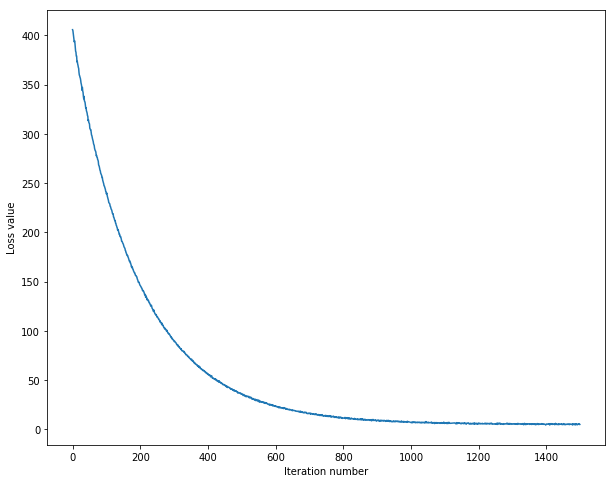

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.380163
validation accuracy: 0.399000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]
for lr, reg in grid:
    est = LinearSVM()
    svm.train(
        X_train, 
        y_train, 
        learning_rate=lr, 
        reg=reg,
        num_iters=1500, 
        verbose=True
    )
    y_train_pred = svm.predict(X_train)
    y_val_pred  = svm.predict(X_test)
    if 

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

SyntaxError: ignored

In [0]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [maqth.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

NameError: ignored

In [0]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
